# Integrating Networks with Temperature Evolution

So far, when integrating a reaction network in python, we've been solving

$$\frac{d{\bf Y}}{dt} = {\bf f}({\bf Y})$$

where ${\bf f}({\bf Y})$ is provided by the {py:obj}`PythonNetwork <pynucastro.networks.python_network.PythonNetwork>` `rhs()` function that is generated by {py:meth}`write_network <pynucastro.networks.rate_collection.RateCollection.write_network>`.

Now we want to instead solve the system:

$$\frac{d{\bf Y}}{dt} = {\bf f}(T, {\bf Y})$$

$$\frac{dT}{dt} = \frac{\epsilon(T, {\bf Y})}{c_x}$$

where $\epsilon$ is the specific energy generation rate from the network and $c_x$ is a specific heat (usually volume or pressure, depending on the application).

```{note}
The `rhs` and `jacobian` functions produced by `write_network` do not include temperature evolution, so we will need to wrap the `rhs` function and have the integrator approximate the Jacobian via differencing.
```

Let's start with a simple He-burning network.

In [1]:
import pynucastro as pyna

In [2]:
net = pyna.network_helper(["p", "he4", "c12", "n13", "o16", "ne20"])

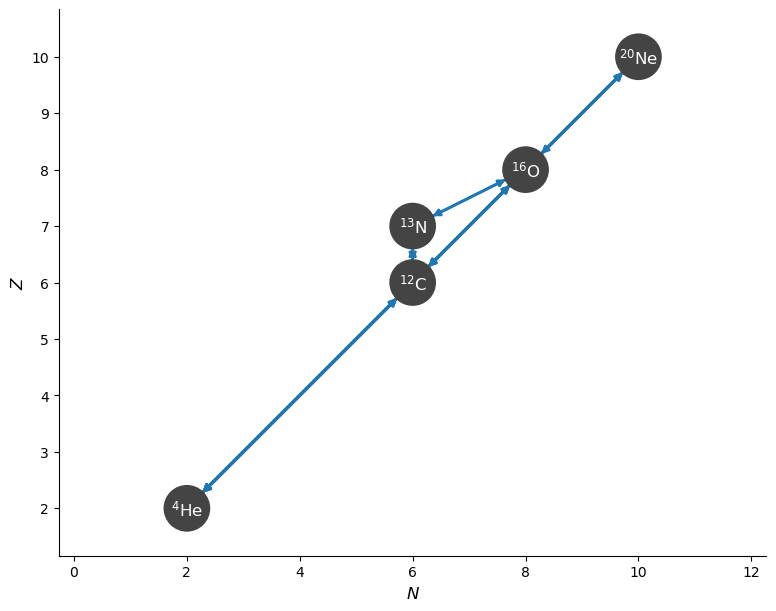

In [3]:
fig = net.plot()

## No temperature evolution

First we'll integrate without evolving the temperature.

In [4]:
from scipy.integrate import solve_ivp
import numpy as np

In [5]:
rho = 1.e5
T = 2.e8

comp = pyna.Composition(net.unique_nuclei)
comp.X[pyna.Nucleus("he4")] = 1
comp.normalize()
Y0 = np.array(list(comp.get_molar().values()))

In [6]:
tmax = 1.e7

In [7]:
net.write_network("henet.py")
import henet

/home/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:117: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/home/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:117: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))


In [8]:
sol = solve_ivp(henet.rhs, [0, tmax], Y0, method="BDF", jac=henet.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-6)

In [9]:
import matplotlib.pyplot as plt

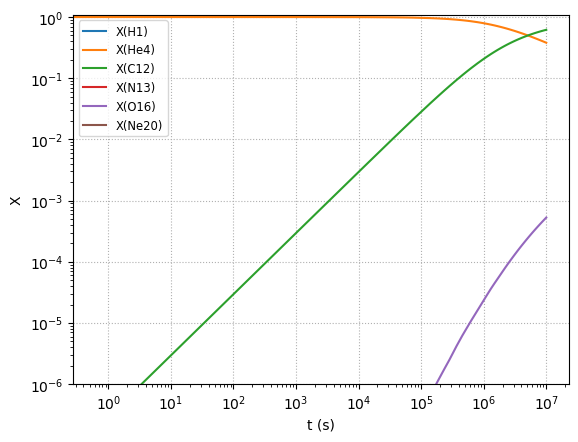

In [10]:
fig, ax = plt.subplots()

for i in range(henet.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * henet.A[i], label=f"X({henet.names[i].capitalize()})")

ax.set_ylim(1.e-6, 1.1)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")
ax.grid(ls=":")

We see it takes about $10^6$ s for the He mass fraction to start to deplete significantly.

## Evolving temperature

We'll call our vector of unknowns $\xi = ({\bf Y}, T)$.

Now we'll write our wrapper that computes $d\xi/dt$, leveraging the network module we created with {\tt write_network}.  In fact, we'll pass that module into `rhs_new` as an argument, so we can easily use what's needed from it.

Inside this function, we'll call the EOS each time to get the updated specific heat.

In [11]:
def rhs_new(t, xi, pynet, rho):

    # unpack the incoming xi
    nspec = len(xi) - 1
    Y = xi[0:nspec]
    T = xi[-1]
    
    dxidt = np.zeros_like(xi)

    # first get the dYdt from our network module
    dxidt[0:nspec] = pynet.rhs(t, Y, rho, T)

    # now get the energy generation rate using this dY/dt
    eps = pynet.energy_release(dxidt[0:nspec])

    # use the EOS to get the specific heat
    eos = pyna.StellarEOS()
    comp = pynet.to_composition(Y)
    state = eos.pe_state(rho, T, comp)

    # and finally compute dT/dt
    dxidt[-1] = eps / state.c_v

    return dxidt
    

Now we'll integrate this new system.  We need to pass in both the network module and density are `args`, but
we no longer pass temperature this way, since it is now one of the dependent variables in the ODE system.

In [12]:
xi0 = np.append(Y0, T)
sol2 = solve_ivp(rhs_new, [0, tmax], xi0, method="BDF",
                dense_output=True, args=(henet, rho), rtol=1.e-6, atol=1.e-6)

Now we can visualize.  First the composition.

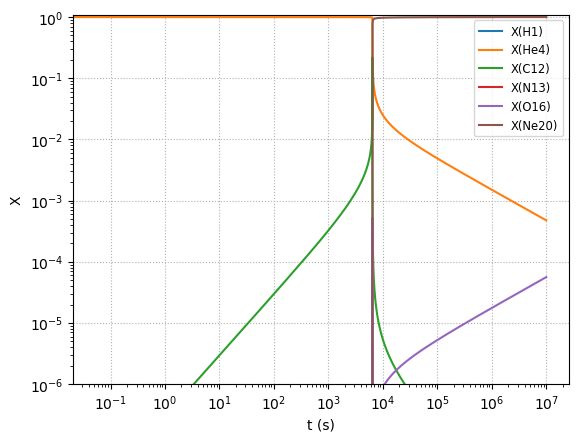

In [13]:
fig, ax = plt.subplots()

for i in range(henet.nnuc):
    ax.loglog(sol2.t, sol2.y[i,:] * henet.A[i], label=f"X({henet.names[i].capitalize()})")

ax.set_ylim(1.e-6, 1.1)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")
ax.grid(ls=":")

This looks dramatically different than the fixed-temperature case.  This is not too surprising, since at these temperatures, the 3-$\alpha$ rate is very temperature sensitive, so as the temperature increases due to the energy release from burning, the He burning rate increases dramatically.

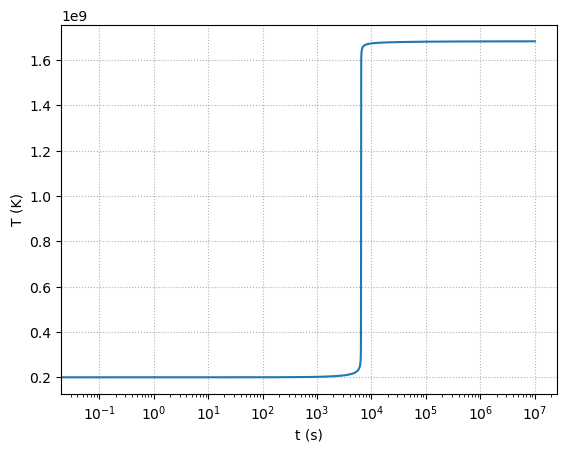

In [14]:
fig, ax = plt.subplots()
ax.semilogx(sol2.t, sol2.y[-1,:])
ax.set_xlabel("t (s)")
ax.set_ylabel("T (K)")
ax.grid(ls=":")

We see that the temperature increased from $2\times 10^8$ K to over $1.6\times 10^9$ K.

It is straigtforward to include thermal neutrino loses in the temperature evolution equation as well,
using the {py:meth}`sneut5 <pynucastro.neutrino_cooling.sneut5_mod.sneut5>` method.